In [1]:
import pandas as pd
from get_comments import main
from path import Path
import os
import time
from tqdm.auto import tqdm
import numpy as np
import json

In [2]:
df = pd.read_csv('./change_org_petitions_Amber_Heard_at_20221002-105030_limit_2000_offset_0_delay_ms_5000.csv')
df_manual = pd.read_csv('./data/manual_petition_slugs.csv')
df_status = pd.read_csv('./data/all_petitions_status_manual.csv')

In [3]:
slug_to_status = dict(zip(df_status.slug, df_status.status))

In [4]:
slugs = list(df['petition.slug']) + list(df_manual.slug)
slugs = [x for x in slugs if isinstance(x, str)]
slugs = [x for x in slugs if slug_to_status[x] != 'irrelevant']

In [5]:
len(slugs)

459

In [ ]:
error_slugs = set()
for slug in tqdm(slugs):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 0, 'offset': 0, 'limit': 1000000})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            #raise e
            print(slug, e)
            error_slugs.add(slug)

In [7]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

set()

In [8]:
# merging everything into a single dataframe

In [9]:
l = os.listdir('./data')
fs = []
prefix = 'change_org_comments_petition_slug_'
for filename in l:
    f = os.path.basename(filename)
    
    if not(filename.startswith(prefix) and filename.endswith('.csv')):
        continue
    slug = f[len(prefix):f.index('_limit_')]
    # print(slug)
    if slug not in slugs:
        continue
    fs.append('./data/' + filename)

In [10]:
def read_set_slug(f):
    try:
        df = pd.read_csv(f)
        slug = os.path.basename(f)[len(prefix):f.index('_limit_') + 1]
        df['petition__slug'] = [slug] * len(df)
        return df
    except:
        return None

In [11]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

  0%|          | 0/457 [00:00<?, ?it/s]

/home/sergia/miniconda3/envs/rst-changeorg-data/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [12]:
for c in df.columns:
    if c.startswith('commentable_entity') and c != 'commentable_entity.slug':
        del df[c]

In [13]:
df['status_manual'] = [slug_to_status[t] for t in df['commentable_entity.slug']]
df.to_csv(f"./data/all_petitions_comments_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

In [14]:
column_size = {c: len(json.dumps(list(df[c]))) for c in tqdm(df.columns)}

  0%|          | 0/45 [00:00<?, ?it/s]

In [15]:
from collections import Counter
Counter(column_size).most_common()

[('comment', 9483987),
 ('petition__slug', 3743659),
 ('commentable_entity.slug', 3284371),
 ('user.photo.sizes.medium.url', 1619373),
 ('user.photo.sizes.large.url', 1619373),
 ('user.photo.sizes.xlarge.url', 1619373),
 ('user.photo.sizes.small.url', 1585211),
 ('created_at', 1377864),
 ('user.display_name', 1057622),
 ('user.photo.url', 1004457),
 ('user.slug', 736100),
 ('user.city', 692491),
 ('user.id', 645521),
 ('role', 638217),
 ('user.last_name', 637162),
 ('id', 631521),
 ('status_manual', 622625),
 ('user.first_name', 592691),
 ('user.short_display_name', 592619),
 ('commentable_id', 573909),
 ('user.locale', 522453),
 ('commentable_type', 516699),
 ('user.description', 429226),
 ('user.photo.id', 413647),
 ('user.roles', 344466),
 ('user.country_code', 344454),
 ('user.website', 339111),
 ('user.state_code', 324016),
 ('user.photo.sizes.medium.size.width', 321217),
 ('user.photo.sizes.medium.size.height', 321217),
 ('user.photo.sizes.large.size.width', 321217),
 ('user.phot

# Optional: plotting

In [16]:
from matplotlib import pyplot as plt

In [17]:
sum([len(t) for t in df.comment])

8991737

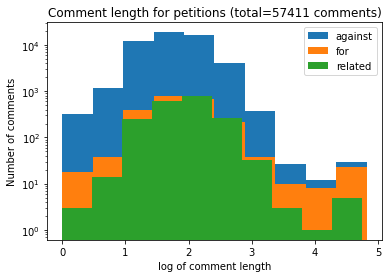

In [18]:
plt.title("Comment length for petitions (total=%d comments)" % len(df))
plt.xlabel("log of comment length")
plt.ylabel("Number of comments")
for status, group in df.groupby('status_manual'):
    plt.hist([np.log10(len(t)) for t in group.comment], label=status)#, log=True)
plt.legend()
plt.yscale('log')
plt.savefig('./figures/comments_length_hist.png', bbox_inches='tight')
plt.show()

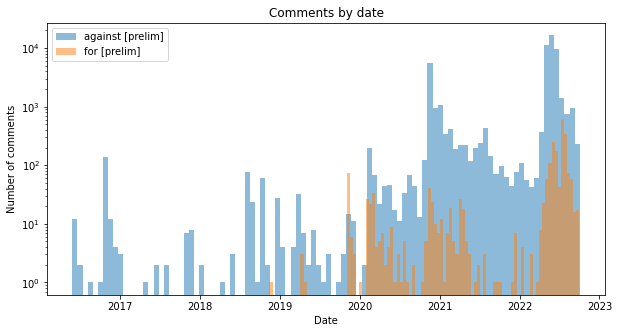

In [41]:
plt.figure(figsize=(10, 5))
plt.hist(pd.to_datetime(df[df['status_manual'] == 'against'].created_at), bins=100, label='against [prelim]', alpha=0.5)
plt.hist(pd.to_datetime(df[df['status_manual'] == 'for'].created_at), bins=100, label='for [prelim]', alpha=0.5)
#plt.hist(pd.to_datetime(df[df['status_manual'] == 'related'].created_at), bins=100, label='related', alpha=0.5)
#plt.hist(pd.to_datetime(df.created_at), bins=100, label='all', alpha=0.5)
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Number of comments')
plt.title('Comments by date')
plt.legend()
plt.savefig('./figures/comments_bydate.png', bbox_inches='tight')
plt.show()